### Hi, let check out this dataset

#### Here is what I gonna do 

1. Check the dataset description from source - Just get more information, I dont trust them. lol
2. Listen to the data by myself => Avoid me making some dumb assumptions
3. Check label
4. Plot some audios in raw and spectrogram form, etc => To think of a good representation for this
5. Verify some basic assumption about train - test - val
6. Can we reduce the input size
7. How we going to train this dataset

In [1]:
import torch
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from torchaudio.datasets import SPEECHCOMMANDS

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

import glob
from pathlib import Path
import random
from IPython.display import Audio, display
from ipywidgets import widgets

from utils.visualize_utils import log_specgram, plot_audio, plot_fft

### Dataset description -- SpeechCommands V1
#### References
- [Official release](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html)  
- [Huggning face description](https://huggingface.co/datasets/speech_commands)
- [Torch dataset api](https://pytorch.org/audio/stable/datasets.html#speechcommands)


#### Extracted info
1. Data set created by thousands of different people, contributed by members of the public through the AIY website
2. The dataset has 65,000 one-second long utterances of 30 short words
3. Dataset is in English
4. Dataset include some common words(yes, no, etc)
5. There are unknown class contain random words
6. There are silence class contain only background noise

In [2]:
# download dataset
_ = SPEECHCOMMANDS("./data", download=True, url='speech_commands_v0.02')
source_data_path = Path('data/SpeechCommands/speech_commands_v0.02')

### Let's listen to some audio samples

In [3]:
audio_files = list(source_data_path.glob('**/*.wav'))
audio_widgets = []
for file in random.sample(audio_files, 10):
    sample_rate, audio = wavfile.read(file)
    out = widgets.Output()
    with out:
        display(Audio(data=audio, rate=sample_rate))
    audio_widgets.append(out)
widgets.HBox(audio_widgets)


#### What we get

1. Multiple recording device was used
2. Audio generally clean - but a about 20% audio I check have background noise
3. The audio part is not cover all 1 seconds sometime there are 50% of audio is silence
4. There are some mic artifact in the audio - sound like people turn the mic on

### Label exploration

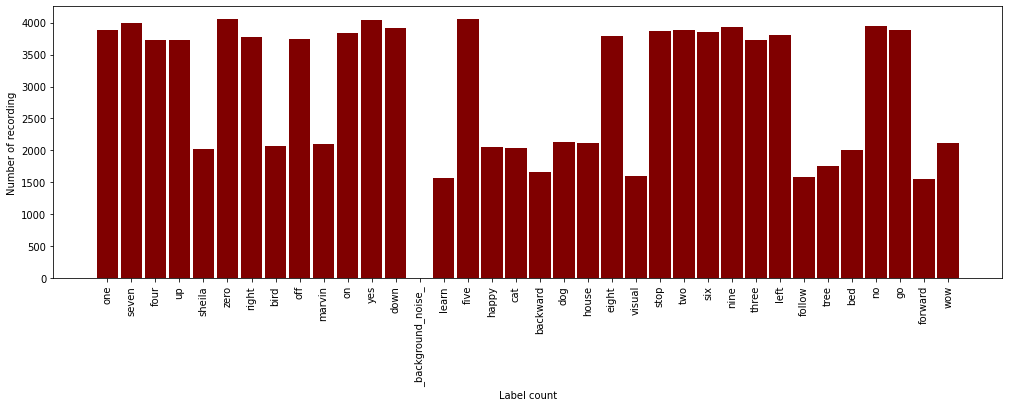

In [4]:
labels = []
count_labels = []
for path in source_data_path.iterdir():
    if path.is_dir():
        labels.append(path.name)
        count = len(list(path.glob('*.wav')))
        count_labels.append(count)
 
# creating the bar plot
fig = plt.figure(figsize = (17, 5))
plt.bar(labels, count_labels, color ='maroon',
        width = 0.9)
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Label count")
plt.ylabel("Number of recording")
plt.show()

#### What we get
1. Dataset quite balace with most of class have 1500-2300 samples
2. The silence class only have 6 files
3. I also do random sampling to check for mislabel data => I dont found any mis-label samples

### Check train - test - val split

In [5]:
# dataset structure
# waveform, sample_rate, label, speaker_id, utterance_number
train_ds = SPEECHCOMMANDS("./data", subset="training", url='speech_commands_v0.02')
test_ds = SPEECHCOMMANDS("./data", subset="testing", url='speech_commands_v0.02')
val_ds = SPEECHCOMMANDS("./data", subset="validation", url='speech_commands_v0.02')
print("train set: ", len(train_ds))
print("test set: ", len(test_ds))
print("val set: ", len(val_ds))

train set:  84843
test set:  11005
val set:  9981


#### Do train - test - val set have overlap speakers?

In [6]:
train_set_speakers = [data[3] for data in train_ds]
test_set_speakers = [data[3] for data in test_ds]
val_set_speakers = [data[3] for data in val_ds]

In [7]:
print(set(train_set_speakers).intersection(test_set_speakers))
print(set(train_set_speakers).intersection(val_set_speakers))
print(set(test_set_speakers).intersection(val_set_speakers))

set()
set()
set()


#### what we get
1. The train - test - val is divided 80-10-10% => which is fine
2. There are no overlap speakers between train - test - val

### Visualize wave and spectrogram

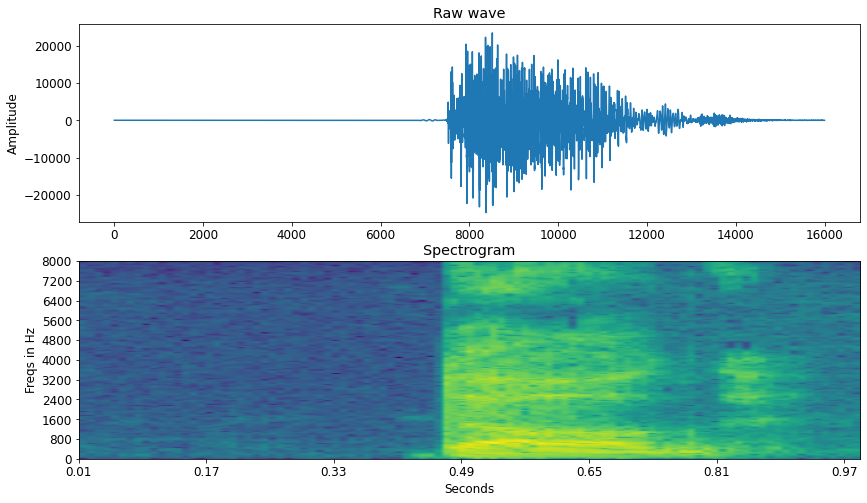

In [8]:
file = 'data/SpeechCommands/speech_commands_v0.02/dog/0a2b400e_nohash_0.wav'
plot_audio(file)

In [ ]:
file = 'data/SpeechCommands/speech_commands_v0.02/bird/0a9f9af7_nohash_1.wav'
plot_audio(file)

#### What we get 
1. The audio contain some redundant audio - match with what I hear
2. There are some perfect silence in some audio - which can be an editing artifact => I dont think It would affect training much 
3. The duration of the audio array from dataset is not uniform ~=16000 => We have to use padding if we choose model with fix size input

### Can we reduce the size of the input?
#### Let do some fft to find upper frequency bound

In [ ]:
plot_fft('data/SpeechCommands/speech_commands_v0.02/dog/0a2b400e_nohash_0.wav')

In [ ]:
plot_fft('data/SpeechCommands/speech_commands_v0.02/bird/0a9f9af7_nohash_1.wav')

#### Most of frequencies in the data are well below 4000hz
=> From some others source and my judgment let try to resample to reduce input size.

In [ ]:
new_sample_rate = 8000

sample_rate, samples = wavfile.read('data/SpeechCommands/speech_commands_v0.01/cat/0ab3b47d_nohash_1.wav')
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))


In [ ]:
ipd.Audio(samples, rate=sample_rate)

In [ ]:
ipd.Audio(resampled, rate=new_sample_rate)

#### What we get
1. From FFT we know that most frequencies in the data are lower than 4000hz
2. Resample audio from 16000hz -> 8000hz dont change the audio much, I still can hear the audio clearly